
# Mass–Spring: Estimating Parameters from $x(t)$  
**Two simple techniques with simulated data (Method A: derivative regression; Method B: ODE-fit).**

**Goal.** From sampled positions $x(t_i)$ (centered as $y=x-x_{eq}$), estimate physical parameters of a damped mass–spring system using two approaches:

- **Method A (Derivative Regression):** fit $\ddot y = -a\,\dot y - b\,y$ to obtain $\omega_0=\sqrt{b}$, $\zeta=a/(2\omega_0)$ and then $k=m\omega_0^2$, $b_{visc}=2m\zeta\omega_0$.
- **Method B (ODE Fit):** integrate $m\ddot y + b\,\dot y + k\,y=0$ and choose $k,b$ to minimize $\sum_i[y_{data}(t_i)-y_{model}(t_i;k,b)]^2$.


In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

np.set_printoptions(precision=6, suppress=True)



## 1) Simulated dataset
We simulate a lightly damped oscillator:
$ y(t) = A\,e^{-\gamma t}\cos(\omega_d t + \phi) $, where $\gamma = \zeta\,2\,\omega_0$ and $\omega_d=\sqrt{\omega_0^2-\gamma^2}$. We then add small Gaussian noise to mimic measurement conditions.


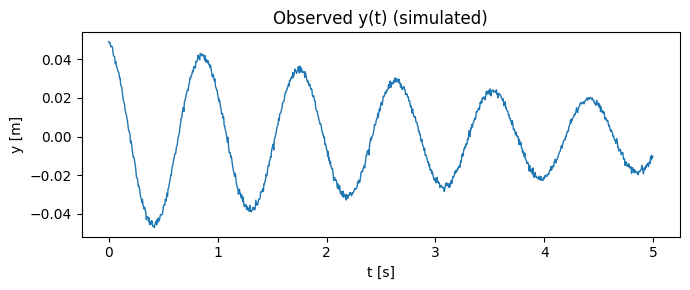

In [2]:

# Ground truth parameters (feel free to edit)
m_true = 0.200    # kg (effective mass)
k_true = 10.0     # N/m
zeta_true = 0.03  # dimensionless damping ratio
A_true = 0.05     # m
phi_true = 0.2    # rad

# Derived ground-truth quantities
omega0_true = np.sqrt(k_true / m_true)
gamma_true = 2 * zeta_true * omega0_true
omega_d_true = np.sqrt(max(omega0_true**2 - (gamma_true/2)**2, 1e-12))

# Sampling
T = 5.0
fs = 200.0
t = np.arange(0.0, T, 1.0/fs)

# Clean signal and noisy observation
rng = np.random.default_rng(0)
y_clean = A_true * np.exp(-gamma_true * t/2) * np.cos(omega_d_true * t + phi_true)
noise = rng.normal(0.0, 0.001, size=t.size)
y = y_clean + noise

# Plot the observed time series
plt.figure(figsize=(7,3))
plt.plot(t, y, lw=1)
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Observed y(t) (simulated)")
plt.tight_layout()
plt.show()



## 2) Method A — Derivative Regression
We smooth the data with Savitzky–Golay, compute $\dot y$ and $\ddot y$, and fit the linear model $\ddot y = -a\,\dot y - b\,y$. Then $\omega_0=\sqrt{b}$ and $\zeta=a/(2\,\omega_0)$. With the mass we obtain $k$ and $b_{visc}$.


Method A estimates:
  omega0 ≈ 6.444199 rad/s
  zeta   ≈ 0.018043
  k      ≈ 8.305540 N/m
  b_visc ≈ 0.046510 N·s/m


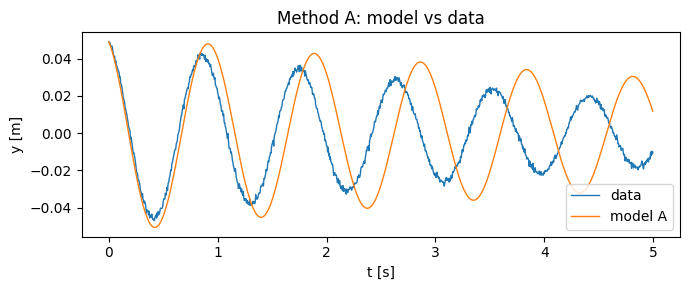

In [3]:

def auto_window_length(N: int) -> int:
    wl = max(5, (N // 10) | 1)   # aim ~ 1/10 of samples, odd
    wl = min(wl, N - (1 - (N % 2)))
    if wl < 5:
        wl = 5 if 5 % 2 == 1 else 7
    if wl >= N:
        wl = N-1 if (N-1) % 2 == 1 else N-2
        if wl < 5:
            wl = 5
    return int(wl)

def fit_derivative_regression(t, y, poly=3, window_length=None):
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    dt = np.median(np.diff(t))
    if window_length is None:
        window_length = auto_window_length(len(t))
    window_length = int(window_length)

    y_s = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1))
    yd = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1), deriv=1, delta=dt)
    ydd = savgol_filter(y, window_length=window_length, polyorder=min(poly, window_length-1), deriv=2, delta=dt)

    X = np.column_stack([yd, y_s])
    rhs = -ydd
    theta, *_ = np.linalg.lstsq(X, rhs, rcond=None)
    a, b = theta
    omega0 = np.sqrt(abs(b))
    zeta = a / (2.0 * omega0) if omega0 > 0 else 0.0
    return dict(a=a, b=b, omega0=omega0, zeta=zeta, y_s=y_s, yd=yd, ydd=ydd)

A = fit_derivative_regression(t, y)
k_A = m_true * (A["omega0"]**2)
b_A = 2 * m_true * A["zeta"] * A["omega0"]

print("Method A estimates:")
print(f"  omega0 ≈ {A['omega0']:.6f} rad/s")
print(f"  zeta   ≈ {A['zeta']:.6f}")
print(f"  k      ≈ {k_A:.6f} N/m")
print(f"  b_visc ≈ {b_A:.6f} N·s/m")

# Optional: build a model signal by integrating with A's implied k,b and the observed initial conditions
def simulate_ode(t, y0, v0, m, k, b):
    def f(_t, z):
        y, v = z
        return [v, -(b/m)*v - (k/m)*y]
    sol = solve_ivp(f, (t[0], t[-1]), [y0, v0], t_eval=t, method="RK45", rtol=1e-6, atol=1e-9)
    return sol.y[0]

y0 = y[0]
v0 = (y[1]-y[0]) / (t[1]-t[0])
yhat_A = simulate_ode(t, y0, v0, m_true, k_A, b_A)

plt.figure(figsize=(7,3))
plt.plot(t, y, lw=1, label="data")
plt.plot(t, yhat_A, lw=1, label="model A")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Method A: model vs data")
plt.legend()
plt.tight_layout()
plt.show()



## 3) Method B — ODE Fit (nonlinear)
We fit $k,b$ by integrating the ODE and minimizing the squared residuals. We start from Method A as an initial guess.


Method B estimates:
  omega0 ≈ 7.014599 rad/s
  zeta   ≈ 0.033025
  k      ≈ 9.840921 N/m
  b_visc ≈ 0.092664 N·s/m


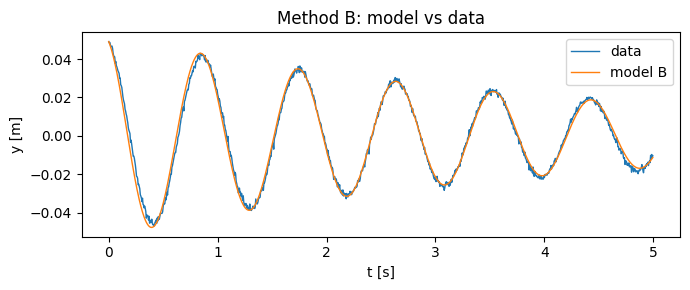

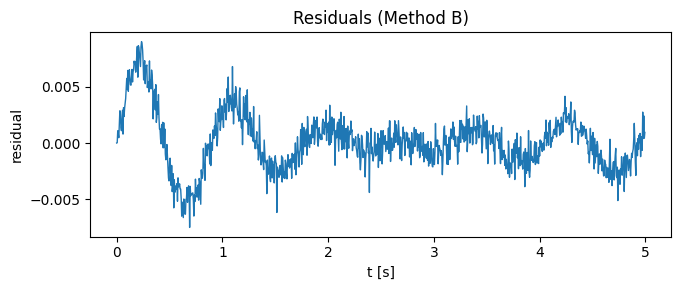

In [4]:

def fit_ode(t, y, m, k0, b0):
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    dt = np.median(np.diff(t))
    y0 = y[0]
    v0 = (y[1]-y[0])/dt if len(t)>1 else 0.0

    def simulate(k, b):
        def f(_t, z):
            yy, vv = z
            return [vv, -(b/m)*vv - (k/m)*yy]
        sol = solve_ivp(f, (t[0], t[-1]), [y0, v0], t_eval=t, method="RK45", rtol=1e-6, atol=1e-9)
        return sol.y[0]

    def residual(theta):
        k, b = theta
        yhat = simulate(k, b)
        return yhat - y

    res = least_squares(residual, x0=np.array([k0, b0]), bounds=([1e-9, 0.0],[np.inf, np.inf]), method="trf", loss="huber", f_scale=1.0)
    k_fit, b_fit = res.x
    omega0 = np.sqrt(k_fit / m)
    zeta = b_fit / (2*m*omega0) if omega0>0 else 0.0
    yhat = simulate(k_fit, b_fit)
    return dict(k=k_fit, b=b_fit, omega0=omega0, zeta=zeta, yhat=yhat, result=res)

B = fit_ode(t, y, m_true, k_A, b_A)
print("Method B estimates:")
print(f"  omega0 ≈ {B['omega0']:.6f} rad/s")
print(f"  zeta   ≈ {B['zeta']:.6f}")
print(f"  k      ≈ {B['k']:.6f} N/m")
print(f"  b_visc ≈ {B['b']:.6f} N·s/m")

plt.figure(figsize=(7,3))
plt.plot(t, y, lw=1, label="data")
plt.plot(t, B["yhat"], lw=1, label="model B")
plt.xlabel("t [s]"); plt.ylabel("y [m]"); plt.title("Method B: model vs data")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,3))
plt.plot(t, y - B["yhat"], lw=1)
plt.xlabel("t [s]"); plt.ylabel("residual")
plt.title("Residuals (Method B)")
plt.tight_layout()
plt.show()



## 4) Summary: truth vs. estimates


In [5]:

summary = pd.DataFrame({
    "quantity": ["omega0 [rad/s]", "zeta [-]", "k [N/m]", "b [N·s/m]"],
    "truth": [omega0_true, zeta_true, k_true, 2*m_true*zeta_true*omega0_true],
    "Method A": [A["omega0"], A["zeta"], m_true*(A["omega0"]**2), 2*m_true*A["zeta"]*A["omega0"]],
    "Method B": [B["omega0"], B["zeta"], B["k"], B["b"]],
})
summary


,quantity,truth,Method A,Method B
0,omega0 [rad/s],7.071068,6.444199,7.014599
1,zeta [-],0.030000,0.018043,0.033025
2,k [N/m],10.000000,8.305540,9.840921
3,b [N·s/m],0.084853,0.046510,0.092664
